## This notebook will walk you through step by step, my preprocessing and modeling pipeline for reddit comment text data.


** First, import all the relevant packages for preprocessing. I make heavy use of pandas/numpy to store text data, nltk for text processing, and scikit for all the modeling. **

** For data plotting, I primarily used a combination of matplotlib and seaborn. **

## Introduction to the project ##

** This note book goes over the model selection for Happy Helper.** Happy Helper takes ~90,000 Google Big Query queries on a stored reddit corpora from /r/depression, /r/anxiety, /r/news, /r/happy, /r/funny, and /r/cute. Feature engineering for these data can be seen in a separate data engineering notebook. Here, the goal is to take the reddit comments, figure out how to do basic natural language processing pre-processing and cleanup, derive a simple bag of words models for classifcation, and utilize different ML models for multi-class classification.

In [1]:
import pandas as pd
import nltk
import numpy as np
import seaborn as sns
from random import randint
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from nltk import ngrams
%matplotlib inline

** Read in the data (extracted from [Google Big Query](https://cloud.google.com/bigquery/)) **

In [2]:
anxiety = pd.read_csv('reddit_anxiety_2.csv')
depression = pd.read_csv('reddit_depress_2.csv')
other = pd.read_csv('other.csv')

**Assign categories to each dataframe.**

In [3]:
anxiety['category'] = 0
depression['category'] = 1
other['category'] = 2

** Create a list of data frames, then concatenate them together into one big data frame. **

In [4]:
frames = [anxiety, depression, other]
data = pd.concat(frames)

**Define a function that will decode all the data from UTF-8 format.** Run the function on the `data` data frame. Specify `selftext` as the column that needs to be decoded.

In [5]:
def decode(dataframe,column_title):
    dataframe[column_title] = dataframe[column_title].astype(str)
    dataframe[column_title] = dataframe[column_title].str.lower()
    dataframe[column_title] = dataframe[column_title].str.decode('utf-8', errors='strict')
    return dataframe

data = decode(data, 'selftext')

** Split the dataset into test and training sets. Also set the category values as individual numpy series.**

In [6]:
train, test = train_test_split(data, test_size = 0.2, random_state = randint(0,500))
y_train = train['category'].values
y_test = test['category'].values

**Define a function that will serve to remove selected stop words.** Stop words are less relevant words and symbols that should not be included in the model. These stop words can be changed to fit the needs of a specific text data set.

The specific function is set to the variable `stop_words`, which will be used later.

In [7]:
def custom_stop():
    custom_stop = stopwords.words('english')
    del custom_stop[109:112]
    custom_stop = set(custom_stop)
    etc_stop = set(('\'ve', '[', ']', '\[\]', '\'s', '\'m', 'n\'t', '``', '\\n', '.', '\.', '...', '-', '\'\'', '(', ')', 'm', 's', 've', ',', ':', '*', '@', '!', '$', '%', '&', '?', '\'', '\"', '\"m', '\"n\'t\"', ' ','removed', 'deleted', '[]','0', 'te'))
    stop_words = custom_stop.union(etc_stop)
    return stop_words

stop_words = custom_stop()

**Define a function named `stems` that pipeline text data into the pre-processing stage.** In order, this function:
    
1. Stem each word using `PorterStemmer()` function in `nltk`.
2. Set all words to lower case.
3. Tokenized all words in text, using `word_tokenize()`.
4. Remove all stop words using `stop_words`.
5. Join all cleaned text to variable `cleaned_text` and return it from the function.

In [8]:
def stems(doc):
    stemmer = PorterStemmer()
    doc = doc.lower()
    #doc_tokens = tokenizer.tokenize(doc)
    doc_tokens = filter(lambda x : x.isalpha(), nltk.word_tokenize(doc))
    doc_stopped_tokens = filter(lambda x : x not in stop_words, doc_tokens) # remove stop tokens
    #doc_stopped_tokens = filter(lambda x: len(x) > 2, doc_stopped_tokens)
    doc_stemmed_tokens =  map(lambda x : stemmer.stem(x), doc_stopped_tokens)
    #doc_lemmatize_tokens = map(lambda x : wordnet_lemmatizer.lemmatize(x), doc_stopped_tokens) # lemmatize
    cleaned_text = " ".join(doc_stemmed_tokens)
    return cleaned_text

** Create a function named `corpus_append` that will append all processed text to a corpora (which is defined as an empty list object).** Note that the stems function is embedded in this particular function.

In [9]:
def corpus_append(dataframe,column_title):
    corpus = []
    for selftext in dataframe[column_title]:
        corpus.append(stems(selftext))
    return corpus

** Create variables `train2` and `test2` from the `corpus_append()` function.**

In [10]:
train2 = corpus_append(train, 'selftext')
test2 = corpus_append(test, 'selftext')

** Define a specific function to do Term-Frequency Inverse Document Frequency vectorization in a single step).**

In [11]:
def tfidf(corpus, num_features):
    from sklearn.feature_extraction.text import TfidfVectorizer
    vectorizer = TfidfVectorizer(analyzer='word',
                    min_df = 0, 
                    stop_words = None, 
                    max_features = num_features)
    data = vectorizer.fit_transform(corpus)
    data = data.toarray(corpus)
    return data

**Apply `tfidf()` to the corpus we generated.** Let's set the number of features to 75. Note the variable names are set to `x_train` and `x_test` to keep with scikit naming conventions.

In [12]:
x_train = tfidf(train2, 75)
x_test = tfidf(test2, 75)

**Call all models used in the project. Note that all parameters would obtained using the `RandomizedSearchCV()` function.**

In [13]:
clf_svm = SGDClassifier(alpha = 1.0000000000000001e-05, l1_ratio = 0.59999999999999998, loss = 'hinge', penalty = 'elasticnet')
clf_rf = RandomForestClassifier(n_estimators=14, max_features = 19, max_depth = 4)
clf_nb = MultinomialNB()
clf_lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage = 0)

**Create a list of models. You can alternatively use the sklearn function `Pipeline` to create a model pipeline**.

In [14]:
models = [clf_svm, clf_rf, clf_nb, clf_lda]

**Do a loop do to cross validation on all models.** Returns a numpy array of mean CV scores for each model.

In [15]:
scores = []
for model in models:
    cv_scores =  cross_val_score(model, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
    scores.append(cv_scores.mean())
scores = np.asarray(scores)
scores

array([-0.1545616 , -0.17252867, -0.28629025, -0.15883812])

**Fit all the models.**

In [17]:
model_name = ['clf_svm', 'clf_rf', 'clf_nb', 'clf_lda']
model_fit_dict = dict()
model_acc_dict = dict()
for i in range(len(models)):
    print models[i]
    print model_name[i]
    models[i] = models[i].fit(x_train, y_train)
    pred = models[i].predict(x_test)
    acc = accuracy_score(y_test, pred)
    model_fit_dict[model_name[i]] = pred
    model_acc_dict[model_name[i]] = acc


SGDClassifier(alpha=1e-05, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.6, learning_rate='optimal',
       loss='hinge', n_iter=5, n_jobs=1, penalty='elasticnet', power_t=0.5,
       random_state=None, shuffle=True, verbose=0, warm_start=False)
clf_svm
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features=19, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=14, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
clf_rf
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
clf_nb
LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=0,
              solver='lsqr', store_covariance=False, tol=0.0001)
clf_lda


**View the predicted values.**

In [18]:
model_fit_dict

{'clf_lda': array([2, 1, 0, ..., 0, 0, 1]),
 'clf_nb': array([1, 1, 0, ..., 0, 0, 2]),
 'clf_rf': array([1, 1, 0, ..., 0, 0, 1]),
 'clf_svm': array([2, 1, 0, ..., 0, 0, 1])}

**View the overall model classification accuracy.**

In [19]:
model_acc_dict

{'clf_lda': 0.88921416681017162,
 'clf_nb': 0.82113541128523049,
 'clf_rf': 0.88232592847712532,
 'clf_svm': 0.89432294357384767}

**Compute confusion matrices.**

In [20]:
cnf_matrix = confusion_matrix(y_test, model_fit_dict['clf_lda'])
np.set_printoptions(precision=2)
cnf_matrix_norm = cnf_matrix / cnf_matrix.astype(np.float).sum(axis=1)

cnf_matrix2 = confusion_matrix(y_test, model_fit_dict['clf_nb'])
np.set_printoptions(precision=2)
cnf_matrix_norm_2 = cnf_matrix2 / cnf_matrix2.astype(np.float).sum(axis=1)

cnf_matrix3 = confusion_matrix(y_test, model_fit_dict['clf_rf'])
np.set_printoptions(precision=2)
cnf_matrix_norm_3 = cnf_matrix3 / cnf_matrix3.astype(np.float).sum(axis=1)

cnf_matrix4 = confusion_matrix(y_test, model_fit_dict['clf_svm'])
np.set_printoptions(precision=2)
cnf_matrix_norm_4 = cnf_matrix4 / cnf_matrix4.astype(np.float).sum(axis=1)

** Confusion Matrix for LDA.**

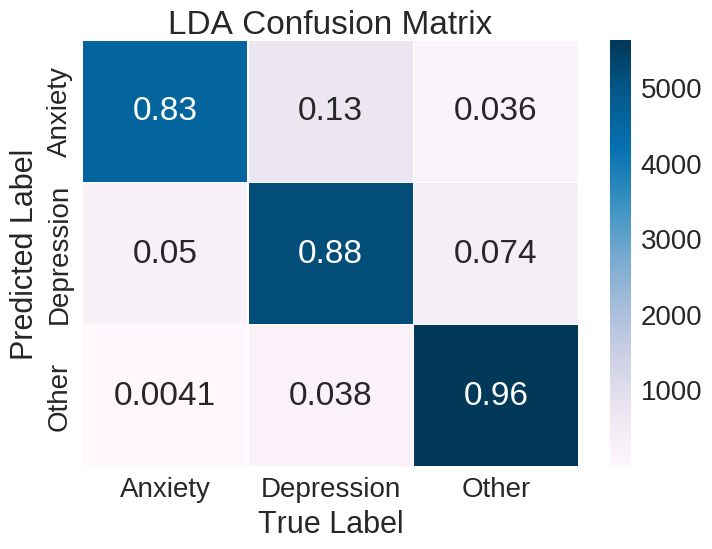

In [21]:
sns.set_style("whitegrid")
sns.set(font_scale=2)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
svm_cm_fig = sns.heatmap(cnf_matrix, 
                         cmap = 'PuBu', 
                         annot = cnf_matrix_norm, 
                         xticklabels = ['Anxiety', 'Depression', 'Other'],
                         yticklabels = ['Anxiety', 'Depression', 'Other'],
                        linewidths = .1,
                        annot_kws={"size":24})
svm_cm_fig.set_title('LDA Confusion Matrix')
svm_cm_fig.set(xlabel='True Label', ylabel='Predicted Label')
# svm_cm_fig.figure.savefig('sns_svm_lda.png', dpi = 400)

** Confusion Matrix for Naive Bayes.**

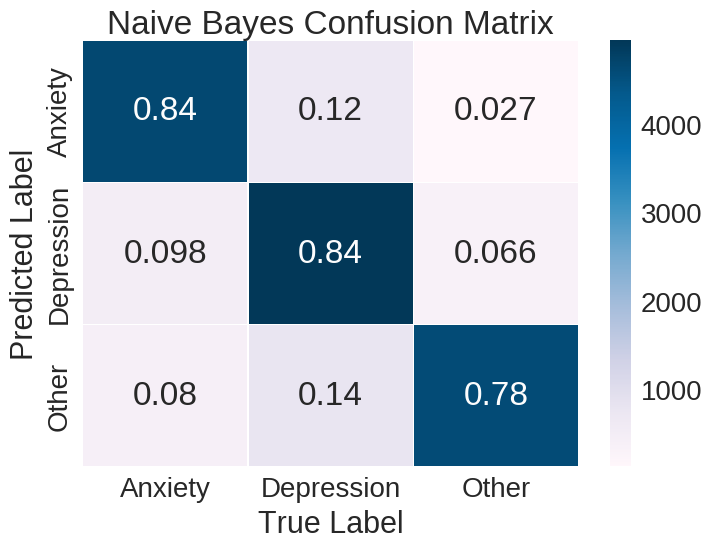

In [22]:
sns.set_style("whitegrid")
sns.set(font_scale=2)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
svm_cm_fig = sns.heatmap(cnf_matrix2, 
                         cmap = 'PuBu', 
                         annot = cnf_matrix_norm_2, 
                         xticklabels = ['Anxiety', 'Depression', 'Other'],
                         yticklabels = ['Anxiety', 'Depression', 'Other'],
                        linewidths = .1,
                        annot_kws={"size":24})
svm_cm_fig.set_title('Naive Bayes Confusion Matrix')
svm_cm_fig.set(xlabel='True Label', ylabel='Predicted Label')
# svm_cm_fig.figure.savefig('sns_svm_lda.png', dpi = 400)

** Confusion Matrix for Random Forest.**

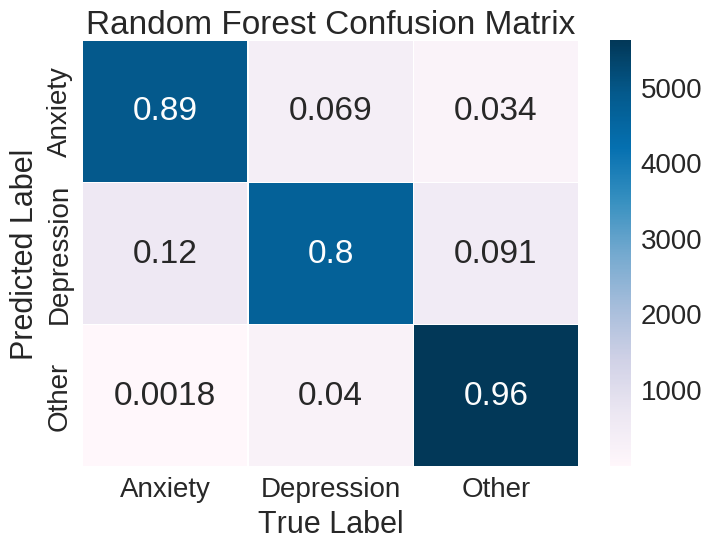

In [23]:
sns.set_style("whitegrid")
sns.set(font_scale=2)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
svm_cm_fig = sns.heatmap(cnf_matrix3, 
                         cmap = 'PuBu', 
                         annot = cnf_matrix_norm_3, 
                         xticklabels = ['Anxiety', 'Depression', 'Other'],
                         yticklabels = ['Anxiety', 'Depression', 'Other'],
                        linewidths = .1,
                        annot_kws={"size":24})
svm_cm_fig.set_title('Random Forest Confusion Matrix')
svm_cm_fig.set(xlabel='True Label', ylabel='Predicted Label')
# svm_cm_fig.figure.savefig('sns_svm_lda.png', dpi = 400)

** Confusion Matrix for SVM with Stochastic Gradient Descent.**

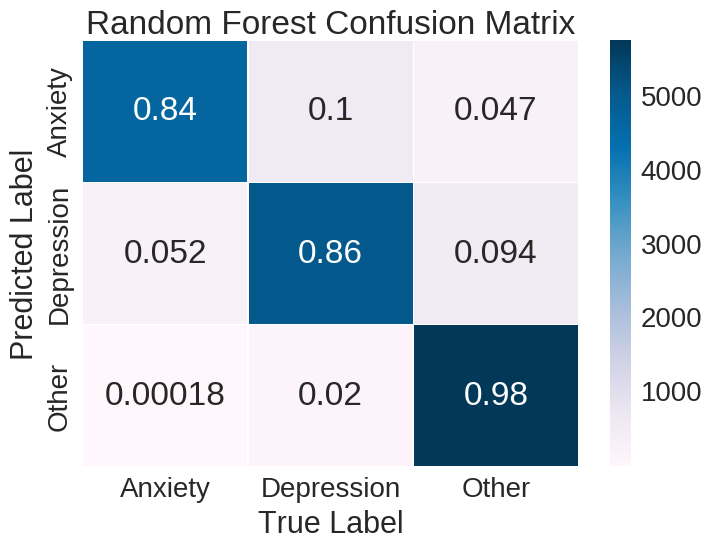

In [24]:
sns.set_style("whitegrid")
sns.set(font_scale=2)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
svm_cm_fig = sns.heatmap(cnf_matrix4, 
                         cmap = 'PuBu', 
                         annot = cnf_matrix_norm_4, 
                         xticklabels = ['Anxiety', 'Depression', 'Other'],
                         yticklabels = ['Anxiety', 'Depression', 'Other'],
                        linewidths = .1,
                        annot_kws={"size":24})
svm_cm_fig.set_title('Random Forest Confusion Matrix')
svm_cm_fig.set(xlabel='True Label', ylabel='Predicted Label')
# svm_cm_fig.figure.savefig('sns_svm_lda.png', dpi = 400)